<a href="https://colab.research.google.com/github/ammobam/Display_SensorData/blob/main/210812_ML_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_%ED%9D%90%EB%A6%84%EC%B4%9D%EC%A0%95%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 머신러닝을 이용한 중요 피처 찾기
- 데이터 : 디스플레이 공정별 센서 측정값. (.csv)

## 할 것
- csv 파일을 넣으면 머신러닝까지 자동으로 수행되도록 함

## 패키지 임포트

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')
#help(pd.read_csv)

## 데이터 불러오기
- 데이터 불러오기
- 원본데이터 보존을 위해 copy 데이터 만들어서 사용하기
- (선택) 생산라인 L, R 구분

In [28]:
# 데이터 불러오기
# 첫번째 열을 인덱스로 사용함
fact_data = pd.read_csv('/content/drive/MyDrive/나무플래닛/1. 데이터_디스플레이/factory_glass_2016.zip', encoding='cp949', index_col=0)
    # encoding : 파일이 안 열리면 인코딩 옵션을 확인하자. utf-8, cp949등으로 설정해봄.
    # index_col : 인덱스로 사용할 columns의 인덱스를 설정

In [29]:
# 데이터 확인
fact_data.info()
fact_data.head()
    # 840 컬럼 x 8145개 행이 있음
    # 데이터 타입은 float과 int형으로 모두 숫자 데이터. 연산 가능함.

<class 'pandas.core.frame.DataFrame'>
Index: 8145 entries, 2016-01-01 07 to 2016-12-31 23
Columns: 840 entries, LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101 to R.Vac
dtypes: float64(834), int64(6)
memory usage: 52.3+ MB


,LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101,LIFT.OUT.ROL.MTR.M2.SPD.1WSI40102,LIFT.OUT.ROL.MTR.M3.SPD.1WSI40103,LEHR.DRV.MTR..M4.1.SPD.1WSI40104,LEHR.DRV.MTR..M4.2.SPD.1WSI40105,LEHR.DRV.MTR..M5.1.SPD.1WSI40106,LEHR.DRV.MTR..M5.2.SPD.1WSI40107,LEHR.DRV.MTR..M6.1.SPD.1WSI40108,LEHR.DRV.MTR..M6.2.SPD.1WSI40109,LEHR.DRV.MTR..M7.1.SPD.1WSI40110,LEHR.DRV.MTR..M7.2.SPD.1WSI40111,LEHR.DRV.MTR..M8.1.SPD.1WSI40112,LEHR.DRV.MTR..M8.2.SPD.1WSI40113,LEHR.DRV.MTR..M9.1.SPD.1WSI40114,LEHR.DRV.MTR..M9.2.SPD.1WSI40115,DRIVE.MOTOR.M10.1.SPEED.1WSI40116,LEHR.DRV.MTR..M10.2.SPD.1WSI40117,LEHR.DRV.MTR..M11.1.SPD.1WSI40118,DRIVE.MOTOR.M11.2.SPEED.1WSI40119,LEHR.DRV.MTR..M12.1.SPD.1WSI40120,LEHR.DRV.MTR..M12.2.SPD.1WSI40121,LEHR.DRV.MTR..M13.1.SPD.1WSI40122,LEHR.DRV.MTR..M13.2.SPD.1WSI40123,LEHR.DRV.MTR..M14.1.SPD.1WSI40124,LEHR.DRV.MTR..M14.2.SPD.1WSI40125,LEHR.DRV.MTR..M15.1.SPD.1WSI40126,LEHR.DRV.MTR..M15.2.SPD.1WSI40127,LEHR.DRV.MTR..M16.1.SPD.1WSI40128,DRIVE.MOTOR.M16.2.SPEED.1WSI40129,LEHR.DRV.MTR..M17.1.SPD.1WSI40130,LEHR.DRV.MTR..M17.2.SPD.1WSI40131,LEHR.DRV.MTR..M18.1.SPD.1WSI40132,LEHR.DRV.MTR..M18.2.SPD.1WSI40133,DRIVE.MOTOR.M19.1.SPEED.1WSI40134,LEHR.DRV.MTR..M19.2.SPD.1WSI40135,X1WOS45101_PV,X1WOS45102_PV,X1WOS45103_PV,X1WOS45104_PV,X1WOS45105_PV,...,S_C1_C2_L_L,S_C1_C2_L_R,S_C2_C3_U_L,S_C2_C3_U_R,S_C2_C3_L_L,S_C2_C3_L_R,S_C3_C4_U_L,S_C3_C4_U_R,S_C3_C4_L_L,S_C3_C4_L_R,S_AB1_AB11_L,S_AB1_AB11_R,S_AB11_AB7_L,S_AB11_AB7_R,S_AB7_C4_L,S_AB7_C4_R,S_C4_RET_L,S_C4_RET_R,S_RET_F_L,S_RET_F_R,STD_U_L,STD_U_R,STD_L_L,STD_L_R,STD_GLS_L,STD_GLS_R,투입.LEFT.,투입.RIGHT.,ROLLDOWN.폐기.LEFT.,진공패드.폐기.LEFT.,ROLLDOWN.폐기.RIGHT.,진공패드.폐기.RIGHT.,폐기율...,ROLLDOWN.진공패드.폐기율..LEFT.,ROLLDOWN.진공패드.폐기율..RIGHT.,ROLLDOWN.진공패드.폐기율..전체.,L.RD,L.Vac,R.RD,R.Vac
dat...date.name.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 07,-1.772682,-1.713219,-1.734851,-1.590051,-1.636293,-1.575213,-1.636293,-1.548119,-1.824581,-1.548119,-1.8189,-1.548119,-1.779407,-1.548119,-1.779407,-1.548119,-1.806012,-1.548119,-1.775051,-1.548119,-1.776634,-1.548119,-1.766604,-1.548119,-1.775051,-1.638207,-1.728206,-1.674911,-1.641818,-1.662151,-1.636293,-1.622314,-1.653428,-1.548119,-1.807954,-1.73,-1.315444,-1.620631,-1.517655,-1.804912,...,-0.195736,0.706941,1.477203,0.410847,0.491620,0.942180,2.776941,2.492437,2.060406,2.612283,1.726404,1.461145,-1.192642,-1.134471,2.599429,2.690433,-0.365598,-0.659319,-1.963403,-1.621407,0.523950,1.951349,2.248106,2.767676,3.012706,3.069007,80,74,2,5,8,3,11.69,8.75,14.86,11.69,0.025,0.063,0.108,0.041
2016-01-01 08,-1.772682,-1.713219,-1.734851,-1.590051,-1.636293,-1.575213,-1.636293,-1.548119,-1.824581,-1.548119,-1.8189,-1.548119,-1.779407,-1.548119,-1.779407,-1.548119,-1.806012,-1.548119,-1.775051,-1.548119,-1.776634,-1.548119,-1.766604,-1.548119,-1.775051,-1.638207,-1.728206,-1.674911,-1.641818,-1.662151,-1.636293,-1.622314,-1.653428,-1.548119,-1.807954,-1.73,-1.315444,-1.620631,-1.517655,-1.804912,...,-0.500742,0.822657,1.495204,0.397591,0.587871,0.938186,2.888919,2.573187,2.161149,2.664726,1.682081,1.414518,-1.109125,-1.042269,2.588703,2.654307,-0.348979,-0.560103,-1.978936,-1.810022,0.566521,2.010125,2.364418,2.842630,3.022998,3.069274,92,75,0,2,10,0,7.19,2.17,13.33,7.19,0.000,0.022,0.133,0.000
2016-01-01 09,-1.772682,-1.713219,-1.734851,-1.590051,-1.636293,-1.575213,-1.636293,-1.548119,-1.824581,-1.548119,-1.8189,-1.548119,-1.779407,-1.548119,-1.779407,-1.548119,-1.806012,-1.548119,-1.775051,-1.548119,-1.776634,-1.548119,-1.766604,-1.548119,-1.775051,-1.638207,-1.728206,-1.674911,-1.641818,-1.662151,-1.636293,-1.622314,-1.653428,-1.548119,-1.807954,-1.73,-1.315444,-1.620631,-1.517655,-1.804912,...,-0.164556,0.962210,1.552127,0.460702,0.397216,0.843443,2.868644,2.486441,2.183298,2.638130,1.632955,1.359022,-0.986580,-0.928583,2.550175,2.606185,-0.456071,-0.644073,-1.878611,-1.742395,0.545936,2.002820,2.397034,2.817728,2.936967,2.969952,64,66,1,4,0,0,3.85,7.81,0.00,3.85,0.016,0.063,0.000,0.000
2016-01-01 10,-1.772682,-1.713219,-

### ** 데이터 복사에 관하여
- 복사를 하는 이유
    - 데이터를 복사하여 작업하면 원본 데이터의 유실을 예방할 수 있음.
    - 같은 데이터를 새로운 객체에 두 번 할당하는 경우에 비해 memory를 아낄 수 있음
- 복사의 종류
    -  a = 10, b = a로 복사하면 참조만 복사. 같은 데이터
    - [mutable문제 발생] 어느 한 쪽을 수정하면 다른 쪽도 변경됨
    - 얕은 복사(.copy())
        - 겉 객체를 복사하여 다른 객체 할당함
        - 원소가 다시 리스트 등의 객체인 경우, 그 원소객체의 참조만 복사되어 mutable 문제가 발생함
    - 깊은 복사(.deepcopy())
        - 겉 객체, 원소 객체가 2중인 경우 그 객체까지 복사 (예시 : 리스트 안에 다시 리스트)
        - mutable한 문제가 해결됨
- 더 알아보기 : 2중 배열 만들어서 copy, deepcopy 비교하기
    - 참고링크 : https://maeng-test-blog.tistory.com/98

In [30]:
# 원본데이터의 보존을 위해 얕은 복사를 수행함
# fact_data 데이터는 숫자형으로 얕은 복사만 수행해도 됨
fact_data_copy = fact_data.copy()

## 데이터 전처리
- 결측치 처리
- 분산 0인 피처 제거
- 상관관계 높은 피처 제거
- VIF > 30 이상의 피처 제거

### 컬럼 제외하기

#### 레이블 컬럼 제외하기

In [31]:
# 레이블 컬럼 제외하기
col_label = ['L.RD', 'L.Vac', 'R.RD', 'R.Vac']
col_use = []
for col in fact_data.columns:
    if col not in col_label:
       col_use.append(col)
print(len(col_use)) # 146개

# 데이터프레임 만들기
fact_data = fact_data[col_use]

836


In [32]:
# 레이블 컬럼에 혹시 결측치 있었나 확인
fact_data_copy[col_label].isnull().sum()
# 없음

L.RD     0
L.Vac    0
R.RD     0
R.Vac    0
dtype: int64

#### 아무리봐도 피처는 아닌 것 같은 컬럼 제거하기

In [33]:
# 아무리봐도 피처는 아닌 것 같은 컬럼 제거하기
col_susang = ['투입.LEFT.', 'ROLLDOWN.폐기.LEFT.', '진공패드.폐기.LEFT.','ROLLDOWN.진공패드.폐기율..LEFT.', '폐기율...']
col_use = []
for col in fact_data.columns:
    if col not in col_susang:
       col_use.append(col)
print(len(col_use)) # 146개

# 데이터프레임 만들기
fact_data = fact_data[col_use]

832


#### Right 컬럼 제외하기

In [34]:
# Right 공정에 해당하는 컬럼
col_right = [   'DB.N2.SCREEN.FLOW.RIGHT.1FI49012_PV',
                 'DB.N2.SCREEN.FLOW.RIGHT.1FI49012_PV.1',
                 'Right.edge',
                 'TMP.TIN..BAY.1.RIGHT.1TI30202.PV',
                 'TMP.TIN..BAY.5.RIGHT.1TI30206.PV',
                 'TMP.TIN..BAY.7.RIGHT.1TI30208.PV',
                 'TMP.TIN..BAY.10.RIGHT.1TI30210.PV',
                 'TMP.GLASS..RIGHT.EXIT.1TIC30111.PV',
                 'X.10.BAY.RIGHT.PRESSURE.1CLBAY10RIGHT_CPV',
                 'X.1.BAY.RIGHT.PRESSURE.1CLBAY1RIGHT_CPV',
                 'X.7.BAY.RIGHT.PRESSURE.1CLBAY7RIGHT_CPV',
                 'RET.AMBIANT.RIGHT.TMP.1TI42603.PV',
                 'BATH.AMBIENT.3.BAY.RIGHT.1TI31002_PV',
                 'EXIT.LIP.PLATE.RIGHT.1TI30605.PV',
                 'E.L.DB.RIGHT.N2.FLOW.1FI33502.PV',
                 'DROSS.BOX.N2.BTM.HT1.R.1JI39006.PV',
                 'DROSS.BOX.N2.BTM.HT..R..1JI39010.PV',
                 'DROSSBOX.N2.SCN.R.1JI39012_PV',
                 'HOOD.N2.HEATER.R..1JI39008.PV',
                 'DDP.RIGHT.N2.H2.9..1FI33421.PV',
                 'SPOUT.RIGHT.UPSTREAM.1FI33516.PV',
                 'SPOUT.RIGHT.BOS.UPSTREAM.1FI33517.PV',
                 'SPOUT.RIGHT.BOTTOM.1FI33518.PV',
                 'SPOUT.RIGHT.TOP.1FI33519.PV',
                 'LOR.1.R.Axis',
                 'LOR.1.R.Hori',
                 'LOR.2.R.Axis',
                 'LOR.2.R.Hori',
                 'LOR.3.R.Axis',
                 'LOR.3.R.Hori',
                 'r_tin_bay_1_5',
                 'r_tin_bay_5_7',
                 'r_tin_bay_7_10',
                 'r_top_n.1_mean',
                 'r_top_n.2_mean',
                 'r_n.2_glass',
                 'D_AB1_R_UL',
                 'D_AB2_R_UL',
                 'D_AB3_R_UL',
                 'D_AB4_R_UL',
                 'D_AB5_R_UL',
                 'D_AB6_R_UL',
                 'D_AB7_R_UL',
                 'D_AB8_R_UL',
                 'D_AB9_R_UL',
                 'D_AB10_R_UL',
                 'D_AB11_R_UL',
                 'D_C1_R_UL',
                 'D_C2_R_UL',
                 'D_C3_R_UL',
                 'D_C4_R_UL',
                 'S_AB1_AB2_U_R',
                 'S_AB1_AB2_L_R',
                 'S_AB2_AB3_U_R',
                 'S_AB2_AB3_L_R',
                 'S_AB3_AB4_U_R',
                 'S_AB3_AB4_L_R',
                 'S_AB4_AB5_U_R',
                 'S_AB4_AB5_L_R',
                 'S_AB5_AB6_U_R',
                 'S_AB5_AB6_L_R',
                 'S_AB6_AB7_U_R',
                 'S_AB6_AB7_L_R',
                 'S_AB7_AB8_U_R',
                 'S_AB7_AB8_L_R',
                 'S_AB8_AB9_U_R',
                 'S_AB8_AB9_L_R',
                 'S_AB9_AB10_U_R',
                 'S_AB9_AB10_L_R',
                 'S_AB10_AB11_U_R',
                 'S_AB10_AB11_L_R',
                 'S_AB11_C1_U_R',
                 'S_AB11_C1_L_R',
                 'S_AB1_AB11_R',
                 'S_AB11_AB7_R',
                 'S_AB7_C4_R',
                 'S_C1_C2_U_R',
                 'S_C1_C2_L_R',
                 'S_C2_C3_U_R',
                 'S_C2_C3_L_R',
                 'S_C3_C4_U_R',
                 'S_C3_C4_L_R',
                 'S_C4_RET_R',
                 'S_RET_F_R',
                 'STD_U_R',
                 'STD_L_R',
                 'STD_GLS_R',
                 '투입.RIGHT.',
                 'ROLLDOWN.폐기.RIGHT.',
                 'ROLLDOWN.진공패드.폐기율..RIGHT.',
                 '진공패드.폐기.RIGHT.']
# 개수 확인
len(col_right) # 91개

91

In [35]:
# Right 컬럼 제외하기
col_use = []
for col in fact_data.columns:
    if col not in col_right:
       col_use.append(col)
print(len(col_use)) # 146개

# 데이터프레임 만들기
fact_data = fact_data[col_use]

741


### 결측치 처리

In [36]:
# 결측치 찾기
nan_data = fact_data.isnull().sum().sort_values(ascending=False)
print(nan_data)
## isnull() : 결측치를 찾아 True/False 리턴함.
    # boolean 데이터타입은 숫자로 변환하면 True -> 1, False -> 0
    # 여기서는 결측치가 있는 데이터는 1의 값을 갖게 됨
## sum() : 컬럼별로 값을 모두 더함
## sort_values() : 값을 크기별로 정렬함
    # ascending=False 옵션을 주면 내림차순으로 정렬함

ROOF.HEATING.Zone52.1JIC31152.PV        8145
ROOF.HEATING.Zone78.1JIC31178.PV        8145
ROOF.HEATING.Zone76.1JIC31176.PV        8145
LEHR.DRV.MTR..M19.2.CUR.1WII40135.PV    8145
DCS_Offset_RPM_M13.1WOS45113_PV         8145
                                        ... 
ROOF.HEATING.Zone10.1JIC31110.PV           0
ROOF.HEATING.Zone.9.1JIC31109.PV.1         0
ROOF.HEATING.Zone.8.1JIC31108.PV.1         0
ROOF.HEATING.Zone.7.1JIC31107.PV.1         0
LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101          0
Length: 741, dtype: int64


In [37]:
# 이때 결측치 개수 컬럼은 시리즈 타입이므로 슬라이싱 됨. nan 개수 상위 20개 정도 살펴보자.
print(type(nan_data))

# 조회 결과, 7개 컬럼은 전체 8145개의 행이 모두 결측치임. 데이터가 없으므로 삭제.
print(nan_data[:20])

<class 'pandas.core.series.Series'>
ROOF.HEATING.Zone52.1JIC31152.PV        8145
ROOF.HEATING.Zone78.1JIC31178.PV        8145
ROOF.HEATING.Zone76.1JIC31176.PV        8145
LEHR.DRV.MTR..M19.2.CUR.1WII40135.PV    8145
DCS_Offset_RPM_M13.1WOS45113_PV         8145
DCS_Offset_RPM_M14.1WOS45114_PV         8145
UPPER.RET..Z218.TMP.1TIC42601.PV        8145
LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101.1        1
LOWER.C3..Z193TMP.1TIC42454.PV             1
DB.HEAT.BTM.LEFT.2.TMP.1TI40316.PV         1
DB.HEAT.TOP.3.2.TMP.1TI40310.PV            1
DB.HEAT.TOP.2.2.TMP.1TI40309.PV            1
DB.HEAT.TOP.1.2.TMP.1TI40308.PV            1
DB.HEAT.TOP.7.1.TMP.1TI40307.PV            1
DB.HEAT.TOP.6.1.TMP.1TI40306.PV            1
LOWER.C4..Z207.TMP.1TIC42554.PV            1
LEHR.DRV.MTR..M4.1.SPD.1WSI40104.1         1
LIFT.OUT.ROL.MTR.M2.SPD.1WSI40102.1        1
LIFT.OUT.ROL.MTR.M3.SPD.1WSI40103.1        1
DROSS.BOX.N2.BTM.HT..L..1JI39009.PV        1
dtype: int64


In [38]:
# 전체 행이 결측치인 컬럼을 찾고 삭제하기

# 1. 전체 행이 결측치인 컬럼을 찾기
print(nan_data[nan_data.values == fact_data.shape[0]].index.tolist())
    # nan_data에서 다음 조건에 해당하는 컬럼을 찾음
        # nan_data.values : nan_data를 데이터 배열로 만들어줌
        # fact_data.shape -> (행 개수, 열 개수)
            # fact_data.shape[0]는 fact_data 행의 개수임
    # .index : 그때의 컬럼이름(여기선 인덱스)을 추출함
    # .tolist() : 데이터를 리스트 타입으로 변환함

# 2. 해당 컬럼삭제하기
fact_data.drop(nan_data[nan_data.values == fact_data.shape[0]].index.tolist(), axis=1, inplace=True)
    # inplace=True : drop 수행한 결과를 fact_data에 반영할지 여부 설정

# 3. 확인 - 컬럼 수가 줄어들었나 확인 (840개 -> 833개)
fact_data.info()

['ROOF.HEATING.Zone52.1JIC31152.PV', 'ROOF.HEATING.Zone78.1JIC31178.PV', 'ROOF.HEATING.Zone76.1JIC31176.PV', 'LEHR.DRV.MTR..M19.2.CUR.1WII40135.PV', 'DCS_Offset_RPM_M13.1WOS45113_PV', 'DCS_Offset_RPM_M14.1WOS45114_PV', 'UPPER.RET..Z218.TMP.1TIC42601.PV']
<class 'pandas.core.frame.DataFrame'>
Index: 8145 entries, 2016-01-01 07 to 2016-12-31 23
Columns: 734 entries, LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101 to ROLLDOWN.진공패드.폐기율..전체.
dtypes: float64(734)
memory usage: 45.7+ MB


In [39]:
# 그 외 결측치 처리
# 남은 결측치는 ffill로 채워주자
# 이 데이터는 1시간마다 측정한 센서 데이터이므로 전체 컬럼에 대한 평균보다는 이전 행의 값으로 결측치를 처리하는 것이 적절함
fact_data.fillna(method = 'ffill', inplace=True)
    # inplace=True : fillna 수행한 결과를 fact_data에 반영할지 여부 설정

# 확인
fact_data.isnull().sum().sort_values()

LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101     0
ROOF.HEATING.Zone.5.1JIC31105.PV      0
ROOF.HEATING.Zone.6.1JIC31106.PV      0
ROOF.HEATING.Zone.7.1JIC31107.PV.1    0
ROOF.HEATING.Zone.8.1JIC31108.PV.1    0
                                     ..
LOWER.C3..Z196.TMP.1TIC42457.PV       0
UPPER.C4..Z197.TMP.1TIC42501.PV       0
UPPER.C4..Z198.TMP.1TIC42502.PV       0
UPPER.C4..Z200.TMP.1TIC42504.PV       0
ROLLDOWN.진공패드.폐기율..전체.                0
Length: 734, dtype: int64

### 분산 0인 데이터 제거
- 분산이 0인 데이터를 제거하는 이유?
    - 어떤 피처의 분산이 0이라는 것은 그 피처의 데이터가 모든 행에 대해 거의 변하지 않은 것을 의미함
    - 어떤 경우에도 같은 값을 내는 컬럼이 불량률에 영향을 주고 있다고 보기 어려움
- 수행 방법
    - 방법1 : sklearn의 VarianceThreshold 사용
    - 방법2 : var() 사용
- 결과
    - 컬럼수 : 831->818


In [40]:
# 방법1
#from sklearn.feature_selection import VarianceThreshold
#selector = VarianceThreshold()
#df = selector.fit_transform(fact_data)
#print(df.shape)
#df

In [41]:
# 방법 2
# 분산 구하기
df_var = fact_data.var()    # 시리즈
# 확인
print(df_var.describe())

# 분산이 0에 수렴하는 컬럼 확인
## 10e-10 이하면 0에 수렴하는 값으로 간주함
print(df_var[df_var.values <= 10e-10])

# 삭제
fact_data.drop(df_var[df_var.values <= 10e-10].index, axis=1, inplace=True)

# 컬럼 수 확인
print(len(fact_data.columns))

count    7.340000e+02
mean     1.049214e+00
std      1.125586e+00
min      7.538541e-27
25%      1.000223e+00
50%      1.000674e+00
75%      1.000816e+00
max      2.248774e+01
dtype: float64
LEHR.DRV.MTR..M4.2.CUR.1WII40105.PV     7.538541e-27
LEHR.DRV.MTR..M9.1.CUR.1WII40114.PV     7.538541e-27
LEHR.DRV.MTR..M9.2.CUR.1WII40115.PV     7.538541e-27
LEHR.DRV.MTR..M10.1.CUR.1WII40116.PV    7.538541e-27
LEHR.DRV.MTR..M14.1.CUR.1WII40124.PV    7.538541e-27
LEHR.DRV.MTR..M17.2.CUR.1WII40131.PV    7.538541e-27
TMP.TIN..BAY.4.LEFT.1TI30203.PV         7.538541e-27
dtype: float64
727


### 피처 간 상관관계 높은 피처 제거
- 상관관계 : 피처 간의 종속된 정도
- 상관관계가 높은 피처를 제거하는 이유?
    - 두 피처 간의 상관관계가 높다는 것은, 하나의 피처 값이 다른 피처의 값에 큰 영향을 주고있음을 의미함
    - 두 피처는 동일한 원인에 기인하여 변하는 것으로 추측할 수 있음
    - 이를 제거하지 않고 두면 사실상 같은 의미인 데이터가 모델링에 여러 번 반영됨
    - 사실상 종속관계에 있는 피처들이 모델링에 크게 기여하는 것과 같음
    - 모델링에 영향을 미치는 원인들이 모두 비슷한 중요도로 반영되게 하려면 종속성이 낮은 피처들만을 이용하여 모델을 만드는 것이 타당함
- 여기서는 피처 간 상관계수의 절대값이 0.9 이상인 경우를 종속된 것으로 봄


In [42]:
# 모든 컬럼에 대해 상관계수를 구하고 상관계수가 0.9 이상인 컬럼 중 1개만 남기고 모두 제거

# 모든 컬럼에 대해 상관계수의 절대값 구하기
corr_arr = abs(fact_data.corr())

# 상관계수가 0.9 이상인 컬럼 중 1개만 남기고 모두 제거
del_list = []
for i, col in enumerate(corr_arr.columns):
    for j in range(len(corr_arr.index)):
        if i == j:
            continue
        elif corr_arr.index[i] in del_list:           
            break
        # print(i, j, corr_arr.index[j], np.abs(corr_arr.iloc[j,i]))
        if np.abs(corr_arr.iloc[j,i]) >= 0.9:
            del_list.append(corr_arr.index[j])
            # print(corr_arr.index[j], '-->', corr_arr.index[i])
# 확인
len(del_list)

631

In [43]:
# del_list에 있는 컬럼은 제외
total_col = fact_data.columns.tolist()
col_remain = []
for c in total_col:
    if c not in del_list:
        col_remain.append(c)
len(col_remain)

325

In [44]:
# 저장
fact_data = fact_data[col_remain]
fact_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8145 entries, 2016-01-01 07 to 2016-12-31 23
Columns: 325 entries, LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101 to 폐기율...
dtypes: float64(325)
memory usage: 20.3+ MB


### (안함) VIF > 30 이상의 피처 제거

In [45]:
# 화이팅

## 분류 모델링을 위한 전처리
- 325개의 컬럼으로 수행

### 스케일링

In [50]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(fact_data)
fact_data_scaled = scaler.transform(fact_data)


# 데이터 범위 확인
print("스케일링한 데이터 최소값:", fact_data_scaled.min())
print("스케일링한 데이터 최대값:", fact_data_scaled.max())

스케일링한 데이터 최소값: 0.0
스케일링한 데이터 최대값: 1.0000000000000002


### PCA 수행하여 주성분 몇 개가 적절한지 조사
- 적당한 n_components 개수 정하기
- 방법1
    - 설명변수가 급감하는 때의 주성분 인덱스를 찾음
    - 이 경우 최소한의 주성분 개수로 전체 데이터의 경향을 설명할 수 있음
- 방법2
    - 설명변수 비율의 누적합이 0.95일 때의 주성분 개수로 선택할 수 있음
    - 이 경우 전체 데이터의 95%를 설명하기 위한 주성분 개수를 구하는 것과 같음

In [55]:
# PCA 수행
from sklearn.decomposition import PCA

# 피처개수 146개만큼 주성분을 뽑아보자
pca = PCA(n_components=len(fact_data.columns))

# 스케일링한 값을 넣고 fit() 과 transform()을 호출해 PCA 변환 데이터 리턴
pca.fit(fact_data_scaled)
fact_data_pca = pca.transform(fact_data_scaled)

# PCA 수행 후 데이터 확인
print("데이터 구조", fact_data_pca.shape)

# 설명변수
## 각 주성분이 전체 데이터 집합을 얼마나 잘 설명하는지 나타내는 값
print("- 각 주성분의 설명변수 :", pca.explained_variance_[:4])
# 설명변수 비율
## 전체 주성분의 설명변수 비율 합은 1(100%)
print("- 각 주성분의 설명변수 비율 :", pca.explained_variance_ratio_[:4])
# 주성분 행렬
print('- singular value :', pca.singular_values_[:4])

데이터 구조 (8145, 325)
- 각 주성분의 설명변수 : [2.36102173 1.07909775 0.732532   0.39970418]
- 각 주성분의 설명변수 비율 : [0.32151169 0.14694593 0.09975241 0.05442964]
- singular value : [138.66564465  93.74525098  77.23820704  57.05427987]


In [56]:
# PCA 수행 결과를 데이터프레임으로 만들어서 확인

# 컬럼이름 붙이기
pca_columns_name = [f"pca{num+1}" for num in range(fact_data.shape[1])]
# 데이터프레임 만들기
pca_df = pd.DataFrame(fact_data_pca, columns = pca_columns_name, index=fact_data.index)
pca_df.info()
pca_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 8145 entries, 2016-01-01 07 to 2016-12-31 23
Columns: 325 entries, pca1 to pca325
dtypes: float64(325)
memory usage: 20.3+ MB


,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15,pca16,pca17,pca18,pca19,pca20,pca21,pca22,pca23,pca24,pca25,pca26,pca27,pca28,pca29,pca30,pca31,pca32,pca33,pca34,pca35,pca36,pca37,pca38,pca39,pca40,...,pca286,pca287,pca288,pca289,pca290,pca291,pca292,pca293,pca294,pca295,pca296,pca297,pca298,pca299,pca300,pca301,pca302,pca303,pca304,pca305,pca306,pca307,pca308,pca309,pca310,pca311,pca312,pca313,pca314,pca315,pca316,pca317,pca318,pca319,pca320,pca321,pca322,pca323,pca324,pca325
dat...date.name.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 07,3.452527,1.533809,1.323886,1.542712,0.183121,0.656539,-0.011691,0.198646,0.792417,0.933732,0.689587,-0.539740,-0.584063,-0.570702,0.049210,-0.050188,-0.918162,0.469422,-0.033838,0.015427,0.032161,-0.335349,-0.234412,-0.034332,-0.268557,0.450278,-0.178547,-0.002137,0.102945,-0.098039,0.044414,0.134852,0.184106,0.464864,-0.040969,0.071232,0.072646,-0.050108,-0.312152,0.189300,...,0.000245,0.000627,0.000355,0.000538,0.000395,-0.000748,-0.000064,0.000077,0.000186,-0.000101,-0.000941,0.000639,0.000342,0.000560,-0.000317,0.000697,-0.000271,-0.000879,-0.000116,-0.000007,-2.721801e-09,-3.816269e-11,3.839190e-11,-4.212336e-11,8.473320e-12,4.159003e-11,4.358408e-13,-5.512232e-11,-1.247813e-10,-5.828093e-11,7.350097e-12,-2.876308e-11,1.517614e-11,8.517374e-12,-1.087013e-11,-2.806739e-12,3.868135e-11,-1.395923e-11,-3.400296e-11,2.539618e-11
2016-01-01 08,3.437189,1.512892,1.329426,1.540556,0.155383,0.625875,0.025668,0.207212,0.792517,0.946555,0.718398,-0.539722,-0.581252,-0.554636,-0.031841,-0.039051,-0.908817,0.440760,-0.036983,0.034583,-0.008182,-0.374090,-0.208744,-0.022218,-0.273319,0.461592,-0.186129,0.000650,0.052902,-0.044170,0.069446,0.096062,0.110267,0.328989,0.013370,0.016166,0.064801,-0.037249,-0.229233,0.208264,...,-0.000836,0.000311,-0.000058,0.000083,0.000257,-0.000572,-0.000493,0.000450,-0.000522,0.000571,-0.000228,-0.000108,0.000018,0.001072,-0.000369,-0.000010,0.000018,0.000471,-0.000294,-0.000010,-3.066720e-09,1.113339e-09,2.937498e-11,5.103251e-11,3.789058e-12,4.492680e-11,-7.541727e-11,2.976486e-11,3.592476e-11,-1.016878e-11,-5.479823e-11,-3.139265e-11,-1.401166e-11,2.175264e-11,-4.173688e-11,-2.664043e-11,-1.751602e-13,-2.453915e-11,9.139483e-12,2.079229e-11
2016-01-01 09,3.464792,1.526558,1.338462,1.575942,0.159724,0.613717,0.032359,0.147726,0.823774,0.942204,0.717249,-0.556960,-0.563052,-0.504648,0.007678,0.007613,-0.895947,0.382570,-0.000814,0.018554,0.027737,-0.303451,-0.273145,-0.006438,-0.171159,0.422955,-0.211508,0.057228,-0.011271,0.028329,0.047506,0.018358,0.048855,0.453669,0.068625,0.059105,0.101009,-0.069568,-0.265144,0.201140,...,-0.000201,-0.000553,-0.000991,-0.000515,0.000350,0.000359,0.000407,-0.000237,-0.001093,0.000205,0.000187,-0.000661,0.000494,0.000602,-0.000522,0.000343,0.000152,0.000142,-0.000134,-0.000007,9.377311e-11,4.111950e-10,4.609113e-11,-6.280158e-11,-1.905137e-11,9.382512e-11,-1.101218e-11,-1.836513e-11,-2.992896e-11,-2.068506e-11,-2.010470e-11,-3.051983e-11,2.037900e-11,-2.398444e-11,4.358677e-12,6.446795e-12,-2.890889e-11,1.787658e-11,1.679081e-11,-1.388207e-11
2016-01-01 10,3.467155,1.540072,1.328730,1.555071,0.125659,0.643282,0.103772,0.133418,0.757122,0.941931,0.779887,-0.582086,-0.596052,-0.527201,-0.011283,-0.032384,-0.928584,0.431864,-0.042126,0.018688,-0.009855,-0.350683,-0.220539,-0.049981,-0.278155,0.482162,-0.181093,0.012355,0.074217,-0.040835,0.060803,0.051709,0.120123,0.364597,0.049702,0.030957,0.092043,-0.033457,-0.256902,0.213552,...,-0.000274,0.000009,0.000826,-0.000277,-0.000479,-0.000283,-0.000291,0.000329,-0.000086,0.000456,-0.000631,0.000419,-0.000577,0.000142,0.000706,0.000082,-0.000744,-0.000050,0.000171,-0.000009,3.453179e-09,-4.401535e-10,-4.367124e-11,5.530068e-11,2.335987e-11,-4.207952e-11,6.888327e-11,-7.770148e-11,-4.086971e-11,7.277482e-11,-6.885167e-12,5.354312e-11,-3.867547e-12,-1.034372e-11,1.751242e-12,4.565548e-11,3.749349e-11,-4.206563e

#### n_components 개수 정하기 : elbow 이용

Text(0, 0.5, 'explained_variance_')

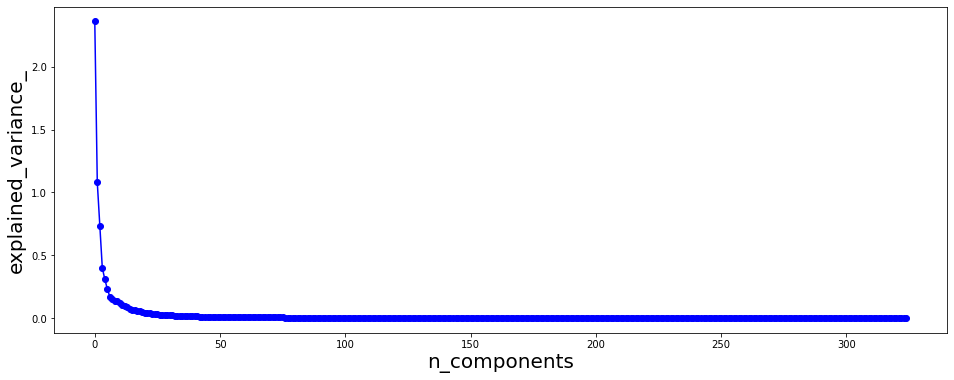

In [57]:
# 방법1
# Scree Plot 그리기
# x축 : n_components 수
# y축 : 설명변수
plt.figure(figsize=(16, 6))
plt.plot(pca.explained_variance_, marker='o', c='blue')
plt.xlabel("n_components", fontsize=20)
plt.ylabel("explained_variance_", fontsize=20)
# Elbow(그래프가 급격히 꺾이는 지점) 확인
# n_components = 7, 즉 주성분 7개로 전체 데이터를 설명할 수 있을 것으로 보임

#### n_components 개수 정하기 : 전체 데이터의 90%를 설명하는 피처 개수

In [88]:
explain_cumsum = 0
for feature_num in range(pca.n_components):
    if explain_cumsum <= 0.9:
        explain_cumsum += pca.explained_variance_ratio_[i]
    else:
        break
print("주성분 {}개로 전체 데이터의 {}%를 설명함".format(feature_num, (explain_cumsum*100).round(3)))

주성분 203개로 전체 데이터의 90.057%를 설명함


In [84]:
# 데이터프레임으로 보기
result = pd.DataFrame({'설명가능한 분산 비율(고윳값)':pca.explained_variance_, '기여율':pca.explained_variance_ratio_},
                      index=pca_columns_name)
result[:10]

,설명가능한 분산 비율(고윳값),기여율
pca1,2.361022,0.321512
pca2,1.079098,0.146946
pca3,0.732532,0.099752
pca4,0.399704,0.054430
pca5,0.308124,0.041959
pca6,0.232358,0.031641
pca7,0.169052,0.023021
pca8,0.152798,0.020807
pca9,0.138835,0.018906
pca10,0.135592,0.018464


### 레이블 기준 설정
- 불량품/양품 나누는 기준

In [85]:
# 타겟 데이터
df_LRD = fact_data_copy.iloc[:, -4]

# 'L.RD' 의 데이터 중 상위 5% 이상이면 불량품, 미만이면 양품으로 결정함
#df_LRD = pd.Series(data = np.where(df_LRD.values > df_LRD.quantile(0.95), 1, 0), name='L.RD', index=origin_data.index)

# 'L.RD' 의 데이터 중 값이 0.01 이상이면 불량품, 미만이면 양품으로 결정함
df_LRD = pd.Series(data = np.where(df_LRD.values >= 0.01, 1, 0), name='L.RD', index=fact_data_copy.index)

print("레이블 개수\n", df_LRD.value_counts())

레이블 개수
 0    4323
1    3822
Name: L.RD, dtype: int64


### 피처 데이터와 레이블 데이터 합치기

In [86]:
# 레이블 없는 데이터에 레이블 시리즈 합치기
fact_data_LRD = pd.concat([fact_data, df_LRD], axis=1)
print(fact_data_LRD.shape)

(8145, 326)


### 훈련/테스트 데이터 나누기

In [87]:
from sklearn.model_selection import train_test_split

# 피처/레이블 데이터 나누기
X = fact_data_LRD.iloc[:, :-1]
y = fact_data_LRD.iloc[:, -1]

# 훈련/테스트 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6108, 325)
(2037, 325)
(6108,)
(2037,)


---
## 분류 모델 수행
- SVM
- Emsemble Method
    - voting : 여러 알고리즘을 사용하여 비교하고 가장 좋은 모델을 선정
        - hard voting(1, 0으로 리턴)
        - soft voting(확률로 리턴)
    - Bagging : 한 가지 알고리즘을 사용하고 데이터 샘플링을 달리하여 비교
    
    - Boosting :이전 모델 훈련 결과 나온 가중치를 다음 모델 훈련에 적용
    - Stacking

### Xgboost
- 파이썬 외부모듈
- 데이터의 구조를 변경해서 사용해야 함
- XGB Classifier 이용
- 참고 : https://statkclee.github.io/model/model-python-xgboost-hyper.html

#### XGBClassifier 사용

In [92]:
# XGB 부스트
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.1, max_depth=7, subsample=0.6)
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='error', eval_set=[(X_test, y_test)], verbose=True)
    # early_stopping_rounds : 100번 이상, 400번 이하로 훈련했을 때 모델 성능이 더이상 나아지지 않는 경우 stop
    ## 115번 째에서 loss 값이 가장 작았으며, 약 200회 정도만 수행해도 모델 성능이 충분히 개선됨

# 분류된 클래스 레이블을 리턴
pred = xgb_wrapper.predict(X_test)
print("######################예측값######################")
print(pred)

# 확률 리턴
pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
print("######################예측확률######################")
print(pred_proba)

[0]	validation_0-error:0.310751
Will train until validation_0-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.303878
[2]	validation_0-error:0.289151
[3]	validation_0-error:0.285714
[4]	validation_0-error:0.279332
[5]	validation_0-error:0.285714
[6]	validation_0-error:0.289151
[7]	validation_0-error:0.286696
[8]	validation_0-error:0.285714
[9]	validation_0-error:0.28326
[10]	validation_0-error:0.280805
[11]	validation_0-error:0.282278
[12]	validation_0-error:0.287187
[13]	validation_0-error:0.281787
[14]	validation_0-error:0.28326
[15]	validation_0-error:0.286205
[16]	validation_0-error:0.283751
[17]	validation_0-error:0.282278
[18]	validation_0-error:0.277369
[19]	validation_0-error:0.27786
[20]	validation_0-error:0.27786
[21]	validation_0-error:0.278841
[22]	validation_0-error:0.279823
[23]	validation_0-error:0.27786
[24]	validation_0-error:0.278351
[25]	validation_0-error:0.281787
[26]	validation_0-error:0.27786
[27]	validation_0-error:0.276387
[28]	validation_0-error:0

### 평가지표
- 어떤 평가지표를 사용할지 고민해야 함
    - 정확도(accuracy) : TN + TP / 전체
    - 정밀도(precision) : TP / (FP + TP)
        - Pos로 예측한 것 중 실제 Pos였던 것
        - 양성예측도
        - Pos 예측 성능을 더 정밀하게 측정하기 위한 평가지표
        - FP를 낮추는 데 초점
    - 재현율(recall) : TP / (FN + TP)
        - 실제 Pos인 것 중 실제 Pos였던 것
        - 민감도, TPR(True Positive Rate)
        - Pos를 Neg로 판단하면 치명적인 경우 사용
        - FN을 낮추는 데 초점
    - F1 Score
        -  2pr/(p+r)
    - ROC 곡선
        - 이진분류의 예측 성능 측정에 사용
        - FP비율 - TP비율(recall) 곡선
- 이 데이터에서는 극소수의 불량품을 판정하지 못하는 것이 치명적임
    - 양품은 고객에게 배송되고, 불량품은 재검수 해보는 과정을 생각해보면
    - 불량품을 양품으로 판정한 경우, 재검수가 이뤄지지 않고 불량품이 고객에게 배송되면 브랜드 이미지에 타격이 가는 등의 치명적인 문제가 발생함
- 따라서 정확도는 적절치 않음. 재현율(recall)이 적절한 지표
    - FP가 높고, FN이 낮은지 중점적으로 살펴야 함
    - F1 Score가 적절할 것 같음

In [32]:
# 평가지표출력
# 오차행렬 : 정확도, 정밀도, 재현율, f1 스코어, roc_auc_score(곡선면적)
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
print("테스트 데이터 수", y_test.shape)

print('오차행렬:\n', confusion_matrix(y_test, pred))
print('정확도:', accuracy_score(y_test, pred).round(3))
print('정밀도:', precision_score(y_test, pred).round(3))
print('재현율:', recall_score(y_test, pred).round(3))
print('f1 스코어:', f1_score(y_test, pred).round(3))

# roc_auc_score는 추정확률을 대입해야 함
print('roc_auc_score:', roc_auc_score(y_test, pred_proba).round(3))

테스트 데이터 수 (2037,)


NameError: ignored

### 하이퍼 파라미터 조정
- GridSearchCV를 이용한 최적의 파라미터 검색
- 수행 시간 오래 걸림

In [ ]:
# 시간 오래걸려서 자동수행을 방지하기 위해 패키지 주석처리함
#from sklearn.model_selection import GridSearchCV

# XGBoost 분류기 생성
xgb_clf = xgb.XGBClassifier()

# 하이퍼파라미터 격자 생성
xgb_param_grid = {'max_depth': [5, 6, 7, 8], 
                  'subsample': [0.55, 0.6, 0.65]}

# GridSearchCV 검증기 생성
xgb_grid = GridSearchCV(estimator=xgb_clf,
                       param_grid=xgb_param_grid,
                       scoring='recall',    # 평가지표 recall 설정 됨!
                       n_jobs=-1,
                       cv=5,
                       refit=True, 
                       return_train_score=True)

# 검증 수행
xgb_grid.fit(X_train, y_train)

In [ ]:
# 검증 결과
xgb_grid_df = pd.DataFrame(xgb_grid.cv_results_)
xgb_grid_df.loc[:, ['mean_test_score', 'params']]


## 최고성능
best_score = xgb_grid.best_score_
# 최고성능을 내는 행을 찾아냄
best_row = xgb_grid.best_index_

# 최적의 하이퍼 파라미터: max_depth, subsample
best_max_depth     = xgb_grid.best_params_["max_depth"]
best_max_subsample = xgb_grid.best_params_["subsample"]

print('예측모형성능(recall):  \t', best_score.round(3))
print('인덱스:  \t', best_row)
print('max_depth:  \t', best_max_depth)
print('subsample:  \t', best_max_subsample)
# recall : 0.398 , max_depth=7, subsample=0.6 채택!

### RFE 클래스를 이용한 중요 피처 선정
- 참고링크
    - https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE
    - https://hongl.tistory.com/116
- RFE
    - recursive feature elimination (재귀적 피처 제거)
    - class sklearn.feature_selection.RFE
    - RFE(estimator, *, n_features_to_select=None, step=1, verbose=0, importance_getter='auto')
        - estimator : 훈련할 모델
        - n_features_to_select : 중요 피처 개수 설정(남길 피처 개수). float으로 설정하면 비율
        - step : 반복할 때마다 삭제할 피처 개수 설정. float으로 설정하면 비율
        - importance_getterstr : 삭제 기준. auto로 두면 회귀에서는 .coef, 분류에서는 feature_importance로 정함

- See also
    - RFECV
        - Recursive feature elimination with built-in cross-validated selection of the best number of features.
    - SelectFromModel
        - Feature selection based on thresholds of importance weights.
    - SequentialFeatureSelector
        - Sequential cross-validation based feature selection. Does not rely on importance weights.

In [94]:
# RFE 이용하여 중요도 낮은 피처를 제거해가며 훈련해보기
# feature_importance_가 낮은 피처를 제거하고 모델 훈련하는 과정을 반복하여 중요한 피처 수를 뽑아냄

# XGB 부스트
from xgboost import XGBClassifier
xgb_wrapper = XGBClassifier(n_estimators = 200, learning_rate = 0.1, max_depth=7, subsample=0.6)

# RFE 수행
from sklearn.feature_selection import RFE
xgb_rfe = RFE(estimator = xgb_wrapper, n_features_to_select = feature_num, verbose=True)    # feature_num : 위에서 pca 분석으로 구함. 전체 데이터의 90%를 설명할 수 있는 n_components 수
xgb_rfe.fit(X_train, y_train)

Fitting estimator with 325 features.
Fitting estimator with 324 features.
Fitting estimator with 323 features.
Fitting estimator with 322 features.
Fitting estimator with 321 features.
Fitting estimator with 320 features.
Fitting estimator with 319 features.
Fitting estimator with 318 features.
Fitting estimator with 317 features.
Fitting estimator with 316 features.
Fitting estimator with 315 features.
Fitting estimator with 314 features.
Fitting estimator with 313 features.
Fitting estimator with 312 features.
Fitting estimator with 311 features.
Fitting estimator with 310 features.
Fitting estimator with 309 features.
Fitting estimator with 308 features.
Fitting estimator with 307 features.
Fitting estimator with 306 features.
Fitting estimator with 305 features.
Fitting estimator with 304 features.
Fitting estimator with 303 features.
Fitting estimator with 302 features.
Fitting estimator with 301 features.
Fitting estimator with 300 features.
Fitting estimator with 299 features.
F

RFE(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                            colsample_bylevel=1, colsample_bynode=1,
                            colsample_bytree=1, gamma=0, learning_rate=0.1,
                            max_delta_step=0, max_depth=7, min_child_weight=1,
                            missing=None, n_estimators=200, n_jobs=1,
                            nthread=None, objective='binary:logistic',
                            random_state=0, reg_alpha=0, reg_lambda=1,
                            scale_pos_weight=1, seed=None, silent=None,
                            subsample=0.6, verbosity=1),
    n_features_to_select=203, step=1, verbose=True)

In [102]:
# 모델 저장
import pickle
with open('/content/drive/MyDrive/나무플래닛/3. 산출물/xgb_rfe.pickle', 'wb') as f:
    pickle.dump(xgb_rfe, f, protocol=pickle.HIGHEST_PROTOCOL)

# 저장한 모델 불러오기
with open('/content/drive/MyDrive/나무플래닛/3. 산출물/xgb_rfe.pickle', 'rb') as f:
    model = pickle.load(f)
model

RFE(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                            colsample_bylevel=1, colsample_bynode=1,
                            colsample_bytree=1, gamma=0, learning_rate=0.1,
                            max_delta_step=0, max_depth=7, min_child_weight=1,
                            missing=nan, n_estimators=200, n_jobs=1,
                            nthread=None, objective='binary:logistic',
                            random_state=0, reg_alpha=0, reg_lambda=1,
                            scale_pos_weight=1, seed=None, silent=None,
                            subsample=0.6, verbosity=1),
    n_features_to_select=203, step=1, verbose=True)

In [96]:
# 선택된(남은) 피처만 필터링
# 203개 컬럼에 대한 데이터
feature_remain = xgb_rfe.transform(X_train)
print(feature_remain.shape)
feature_remain

(6108, 203)


array([[-0.10729677, -0.18069875,  0.0400501 , ..., -1.04879165,
        -0.42174732,  1.61      ],
       [ 0.01688473, -0.29092286,  0.01000868, ..., -0.78593395,
        -0.06966613,  0.        ],
       [ 0.02635918,  0.16291014,  0.19282206, ...,  1.14376837,
        -0.52975569,  6.98      ],
       ...,
       [-1.96420869,  0.43064591, -2.59909988, ...,  9.96945313,
         5.83043207,  0.59      ],
       [-0.53648505, -0.37524549, -0.07684142, ..., -0.22218073,
        -0.21495506,  0.65      ],
       [-0.83502398, -0.10864962, -0.19841481, ...,  0.80761613,
         0.66756352,  2.19      ]])

In [98]:
# 남은 피처 저장
np.save('/content/drive/MyDrive/나무플래닛/3. 산출물/rfe_remain_203', feature_remain)

#### 203개로 줄인 피처 확인

In [164]:
# rfe 객체에서 파라미터 조사

# 모델객체
print(xgb_rfe.estimator_)

# 피처 개수
print(xgb_rfe.n_features_)

# 피처 중요도 랭킹
print('ranking_')
print(xgb_rfe.ranking_)
print(xgb_rfe.ranking_.shape)

# 원래 피처에서 지운 데이터는 False, 남긴 데이터는 True
print('support_')
print(xgb_rfe.support_)
print(xgb_rfe.support_.shape)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6, verbosity=1)
203
ranking_
[123  78  93  92  91  90  88  87  86  84  98  80  83  96  99  97  53 111
 101  81 104 106 102  65  46   1   1   1   1   1   1   8   1   1   1   1
   1   1   1  35  23  20  50   1   1  52  38   1   1   1  55   1   1   1
  11   1  21   1  70   1   1   1  59   1   1 110   1  79 113  85  89 121
 120   1 114 119 115 109  72 108  57  94 117 116  76 103  62   1  95 100
  82  51   1   5   1  64  32  47   1   1  45   1   1   1   1   1   1   1
  40   1   1   2   1  16   1   1   1   1   1  43   1   1   1   1   1   1
  61

#### ■ fact_data_rfe (203개 컬럼)

In [126]:
# rfe로 중요한 피처 203개 목록 받기
mask = xgb_rfe.support_
rfe_col = fact_data.columns[mask].tolist()
print(len(rfe_col))

# 203개 데이터프레임
fact_data_rfe = fact_data[rfe_col]
# 저장
fact_data_rfe.to_csv('/content/drive/MyDrive/나무플래닛/3. 산출물/fact_data_rfe')
fact_data_rfe.info()

203
<class 'pandas.core.frame.DataFrame'>
Index: 8145 entries, 2016-01-01 07 to 2016-12-31 23
Columns: 203 entries, UPPER.AB1.Z1.TMP.1TIC41101.PV to 폐기율...
dtypes: float64(203)
memory usage: 13.0+ MB


In [127]:
# rfe로 추출한 컬럼 203개
rfe_col[:]

['UPPER.AB1.Z1.TMP.1TIC41101.PV',
 'UPPER.AB1.Z6.TMP.1TIC41106.PV',
 'LOWER.AB1.Z9.TMP.1TIC41152.PV',
 'UPPER.AB2.Z20.TMP.1TIC41206.PV',
 'LOWER.AB3.Z37.TMP.1TIC41352.PV',
 'UPPER.AB5.Z57.TMP.1TIC41501.PV',
 'LOWER.AB5.Z69.TMP.1TIC41556.PV',
 'UPPER.AB6.Z71.TMP.1TIC41601.PV',
 'LOWER.AB6.Z78.TMP.1TIC41651.PV',
 'LOWER.AB6.Z83.TMP.1TIC41656.PV',
 'LOWER.AB7.Z92.TMP.1TIC41751.PV',
 'UPPER.AB8.Z99.TMP.1TIC41801.PV',
 'UPPER.AB8.Z101TMP.1TIC41803.PV',
 'LOWER.AB10.Z137.TMP.1TIC42054.PV',
 'UPPER.AB11.Z142.TMP.1TIC42102.PV',
 'UPPER.C1..Z157.TMP.1TIC42203.PV',
 'UPPER.C1..Z158.TMP.1TIC42204.PV',
 'UPPER.C1..Z159.TMP.1TIC42205.PV',
 'LOWER.C1..Z168.TMP.1TIC42257.PV',
 'UPPER.C2..Z169.TMP.1TIC42301.PV',
 'UPPER.C2..Z170.TMP.1TIC42302.PV',
 'UPPER.C2..Z173.TMP.1TIC42305.PV',
 'LOWER.C2..Z176.TMP.1TIC42351.PV',
 'UPPER.C3..Z183.TMP.1TIC42401.PV',
 'LOWER.C3..Z193TMP.1TIC42454.PV',
 'LOWER.C3..Z196.TMP.1TIC42457.PV',
 'UPPER.C4..Z201.TMP.1TIC42505.PV',
 'LOWER.C4..Z204.TMP.1TIC42551.PV',
 'LIFT.

## 새로운 데이터로 다시 모델링

### 데이터 분할

In [169]:
from sklearn.model_selection import train_test_split

# 피처/레이블 데이터 나누기
X = fact_data_rfe   ## 피처만 바뀜
y = fact_data_LRD.iloc[:, -1]

# 훈련/테스트 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6108, 203)
(2037, 203)
(6108,)
(2037,)


### 모델 수행

In [170]:
# XGB 부스트
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.1, max_depth=7, subsample=0.6)
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='error', eval_set=[(X_test, y_test)], verbose=True)
    # early_stopping_rounds : 100번 이상, 400번 이하로 훈련했을 때 모델 성능이 더이상 나아지지 않는 경우 stop
    ## 115번 째에서 loss 값이 가장 작았으며, 약 200회 정도만 수행해도 모델 성능이 충분히 개선됨

# 분류된 클래스 레이블을 리턴
pred = xgb_wrapper.predict(X_test)
print("######################예측값######################")
print(pred)

# 확률 리턴
pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
print("######################예측확률######################")
print(pred_proba)


[0]	validation_0-error:0.312224
Will train until validation_0-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.304369
[2]	validation_0-error:0.287187
[3]	validation_0-error:0.289151
[4]	validation_0-error:0.284732
[5]	validation_0-error:0.289151
[6]	validation_0-error:0.285223
[7]	validation_0-error:0.277369
[8]	validation_0-error:0.279823
[9]	validation_0-error:0.27295
[10]	validation_0-error:0.283751
[11]	validation_0-error:0.281787
[12]	validation_0-error:0.283751
[13]	validation_0-error:0.278841
[14]	validation_0-error:0.281787
[15]	validation_0-error:0.278841
[16]	validation_0-error:0.276878
[17]	validation_0-error:0.274423
[18]	validation_0-error:0.276387
[19]	validation_0-error:0.278841
[20]	validation_0-error:0.276387
[21]	validation_0-error:0.279332
[22]	validation_0-error:0.276387
[23]	validation_0-error:0.278351
[24]	validation_0-error:0.276387
[25]	validation_0-error:0.276878
[26]	validation_0-error:0.274423
[27]	validation_0-error:0.270987
[28]	validation_0-er

### 평가지표

In [171]:
# 평가지표출력
# 오차행렬 : 정확도, 정밀도, 재현율, f1 스코어, roc_auc_score(곡선면적)
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
print("테스트 데이터 수", y_test.shape)

print('오차행렬:\n', confusion_matrix(y_test, pred))
print('정확도:', accuracy_score(y_test, pred).round(3))
print('정밀도:', precision_score(y_test, pred).round(3))
print('재현율:', recall_score(y_test, pred).round(3))
print('f1 스코어:', f1_score(y_test, pred).round(3))

# roc_auc_score는 추정확률을 대입해야 함
print('roc_auc_score:', roc_auc_score(y_test, pred_proba).round(3))

테스트 데이터 수 (2037,)
오차행렬:
 [[773 297]
 [242 725]]
정확도: 0.735
정밀도: 0.709
재현율: 0.75
f1 스코어: 0.729
roc_auc_score: 0.818


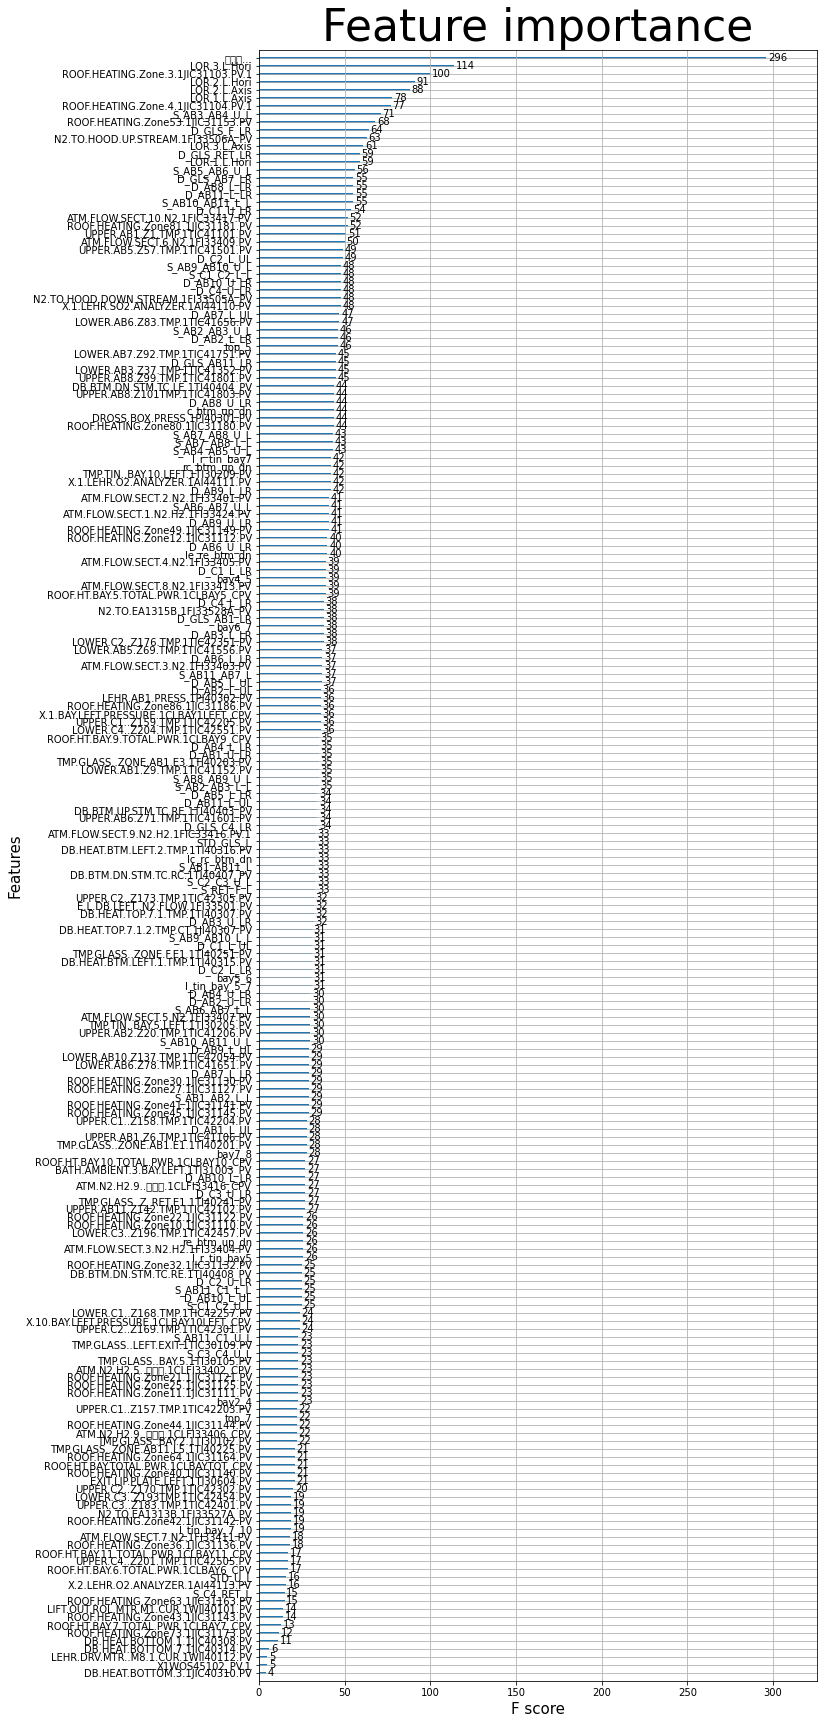

In [176]:
# 특성 중요도 시각화
fig, ax = plt.subplots(figsize=(10, 30))

# xgb는 자체적으로 특성 중요도를 시각화하는 함수(plot_importance)를 제공함
from xgboost import plot_importance
plot_importance(xgb_wrapper, ax)

# 폰트 사이즈
plt.rc('font', size=10)          # controls default text sizes  # 중요도
plt.rc('axes', titlesize=44)     # fontsize of the axes title  # 전체타이틀
plt.rc('axes', labelsize=15)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels # x축
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels # y축
plt.rc('legend', fontsize=8)     # legend fontsize
plt.rc('figure', titlesize=44)   # fontsize of the figure title'''

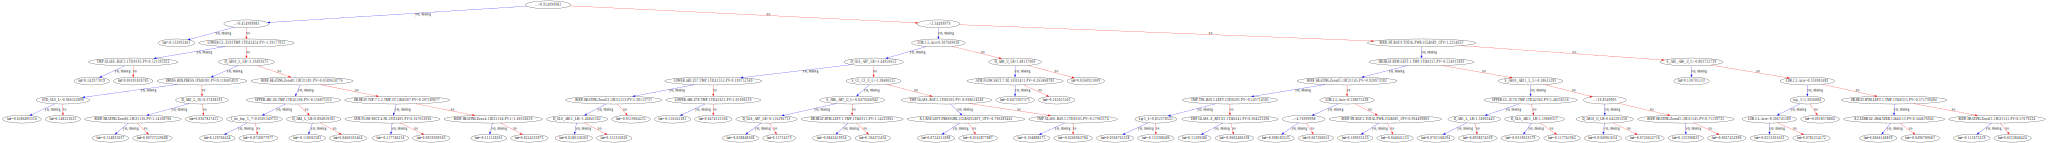

In [180]:
# xgboost 트리구조 확인
import xgboost as xgb
tree_img = xgb.to_graphviz(xgb_wrapper, num_trees=7)
tree_img

In [181]:
type(tree_img)

graphviz.dot.Digraph

In [182]:
# 이미지 저장
from PIL import Image
# 이미지 열기
tree_img.save('/content/drive/MyDrive/나무플래닛/3. 산출물/xgb_203_tree.dot') 

'/content/drive/MyDrive/나무플래닛/3. 산출물/xgb_203_tree.dot'